# How many preliminary experiments?

This notebook shows how smany preliminary experiments $N$ are enough to ensure a reasonable estimation of $n^*$ using $n^*_N$.
We will use different probability distributions over rankings to evaluate this and provide some recommendations.

In [94]:
from typing import OrderedDict

import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.auto import tqdm

from genexpy.kernels import rankings as kru
from genexpy import random as du

figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True, parents=True)
outputs_dir = Path("outputs")
outputs_dir.mkdir(exist_ok=True, parents=True)

seed = 1444
nrep = 100
infty = 5000  # a "very large" N
alpha = 0.95
delta = 0.05
load_precomputed = True

# Distributions
nas = [2, 4, 8, 16]
distrs = [du.UniformDistribution(na=na, seed=seed*na) for na in nas]

# Sizes of preliminary studies
Ns = [10, 20, 40, 80]

First, for all distributions, kernels, and $N$-s (including $\infty$), let's estimate the distribution of the MMD for various $n \leq N // 2$.

In [95]:
dfmmd = None
if load_precomputed:
    try:
        dfmmd = pd.read_parquet(outputs_dir / "dfmmd.parquet")
    except FileNotFoundError:
        pass
    else:
        print(f"[INFO] Loaded existing results from {outputs_dir / 'dfmmd.parquet'}.")

if dfmmd is None:
    out = []
    tmp_seed = seed
    for distr in tqdm(distrs, desc="Distribution", position=0, leave=True):
        # True results (for a very large number of experiments)
        na = distr.na

        # Kernels (not instantiated because we need na)
        kernels = [kru.BordaKernel(idx=0, nu="auto", na=na),
                   kru.JaccardKernel(k=1),
                   kru.MallowsKernel(nu="auto", na=na),
                   ]

        for kernel in tqdm(kernels, desc="Kernel", position=1, leave=False):
            # True value for N = \infty
            sample_infty = distr.sample(infty)
            tmp = kernel.mmd_distribution_many_n(sample_infty, nmin=2, nmax=40, step=2, rep=100, seed=tmp_seed, disjoint=True, replace=False,method="vectorized", N=infty)
            tmp["rep"] = 0
            tmp["distr"] = str(distr)
            tmp["distr_latex"] = distr.latex_str()
            tmp["na"] = na
            out.append(tmp)

            tmp_seed += 1

            # Estimations
            for N in Ns:
                for rep in range(nrep):
                    sample = distr.sample(n=N)
                    # sample = sample_infty.get_subsample(subsample_size=N, seed=tmp_seed)
                    tmp_seed += 1

                    tmp = kernel.mmd_distribution_many_n(sample_infty, nmin=2, nmax=N//2, step=2, rep=100, seed=tmp_seed, disjoint=True, replace=False, method="vectorized", N=N)
                    tmp["rep"] = rep
                    tmp["distr"] = str(distr)
                    tmp["distr_latex"] = distr.latex_str()
                    tmp["na"] = na
                    out.append(tmp)

                    tmp_seed += 1

    dfmmd = pd.concat(out, axis=0)
    dfmmd.to_parquet(outputs_dir / "dfmmd.parquet")


[INFO] Loaded existing results from outputs\dfmmd.parquet.


In [96]:
dfmmd.head()

,n,mmd,method,N,disjoint,replace,kernel,rep,distr,distr_latex,na
0,2,4.435478e-01,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
1,2,0.000000e+00,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
2,2,0.000000e+00,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
3,2,4.435478e-01,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
4,2,1.490116e-08,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2


In [109]:
dfmmd.query("N == 5000")

,n,mmd,method,N,disjoint,replace,kernel,rep,distr,distr_latex,na
0,2,4.435478e-01,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
1,2,0.000000e+00,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
2,2,0.000000e+00,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
3,2,4.435478e-01,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
4,2,1.490116e-08,vectorized,5000,True,False,"BordaKernel(nu=0.50, idx=0)",0,"Uniform(na=2, ties=True)",$U_{2}$,2
...,...,...,...,...,...,...,...,...,...,...,...
1895,38,1.285526e-01,vectorized,5000,True,False,MallowsKernel(nu=0.01),0,"Uniform(na=16, ties=True)",$U_{16}$,16
1896,38,1.566593e-01,vectorized,5000,True,False,MallowsKernel(nu=0.01),0,"Uniform(na=16, ties=True)",$U_{16}$,16
1897,38,1.463237e-01,vectorized,5000,True,False,MallowsKernel(nu=0.01),0,"Uniform(na=16, ties=True)",$U_{16}$,16
1898,38,1.449243e-01,vectorized,5000,True,False,MallowsKernel(nu=0.01),0,"Uniform(na=16, ties=True)",$U_{16}$,16


Next, we compute the quantiles of the mmd.

In [98]:
groupby_keys = ["distr_latex", "na", "kernel", "N", "rep"]

out = []
for group, tmp in dfmmd.groupby(groupby_keys):
    tmp2 = tmp.groupby("n")["mmd"].quantile(alpha, interpolation="higher").rename("q_alpha").reset_index()

    for key, val in zip(groupby_keys, tuple(group)):
        tmp2[key] = val

    out.append(tmp2)

dfq = pd.concat(out, axis=0)

In [99]:
dfq.head()

,n,q_alpha,distr_latex,na,kernel,N,rep
0,2,0.827036,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,0
1,4,0.617147,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,0
0,2,0.865488,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,1
1,4,0.529262,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,1
0,2,0.783971,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,2


Now we predict generalizability for with the quantiles.

In [124]:
from sklearn.linear_model import LinearRegression
from genexpy.kernels.base import Kernel

groupby_keys = ["distr_latex", "na", "kernel", "N", "rep"]

out = []
out_nstar_true = []
for group, dftmp in dfq.groupby(groupby_keys):
    group = tuple(group)

    logq = np.log(dftmp["q_alpha"].values.reshape(-1, 1))
    logn = np.log(dftmp["n"].values.reshape(-1, 1))

    # logn = b1 * logq + b0
    lr = LinearRegression()
    lr.fit(logq, logn)
    b1 = lr.coef_[0, 0]
    b0 = lr.intercept_[0]

    distr = group[0]
    na = group[1]

    kernel = Kernel.from_string(group[2])
    eps = kernel.get_eps(delta, na=na)
    nstar = np.exp(b1 * np.log(eps) + b0)

    out.append(dict(zip(groupby_keys, group),
                    **dict(nstar=nstar)))

    # True n^*, satisfying the definition
    if group[3] == 5000:
        nstar = dftmp.query("q_alpha < @eps")["n"].min()
        out_nstar_true.append(dict(zip(groupby_keys, group),
                **dict(nstar_true=nstar)))

df_nstar = pd.DataFrame(out)
df_nstar_true = pd.DataFrame(out_nstar_true).drop(columns=["N", "rep"])

C:\Users\federicom\AppData\Local\Temp\ipykernel_14292\863463121.py:25: RuntimeWarning: overflow encountered in exp
  nstar = np.exp(b1 * np.log(eps) + b0)


In [125]:
df_nstar.head()

,distr_latex,na,kernel,N,rep,nstar
0,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,0,21.033813
1,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,1,8.651773
2,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,2,11.865063
3,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,3,16.035818
4,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,4,13.946708


In [126]:
df_nstar_true.head()

,distr_latex,na,kernel,nstar_true
0,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",12
1,$U_{16}$,16,JaccardKernel(k=1),32
2,$U_{16}$,16,MallowsKernel(nu=0.01),10
3,$U_{2}$,2,"BordaKernel(nu=0.50, idx=0)",18
4,$U_{2}$,2,JaccardKernel(k=1),30


Are there distributions and kernels for which the true $n^*$ was never achieved?

In [127]:
df_nstar_true["nstar_true"].isna().sum()

np.int64(0)

Finally, we compare the estimated $n^*_N$-s against the one for $N=\infty$.

In [132]:
df_nstar_infty = df_nstar.query("N == @infty").reset_index(drop=True).drop(columns=["rep", "N"])
df_nstar_emp = df_nstar.query("N < @infty").reset_index(drop=True).drop(columns=["rep"])

dfplot = pd.merge(df_nstar_emp, df_nstar_infty, on=["distr_latex", "na", "kernel"], suffixes=("", "_infty"))
dfplot = pd.merge(dfplot, df_nstar_true, on=["distr_latex", "na", "kernel"], suffixes=("", "_true"))

dfplot["nstar_rel_error"] = (dfplot["nstar"] - dfplot["nstar_true"]) / dfplot["nstar_true"]
dfplot["n_star_ratio"] = dfplot["nstar"] / dfplot["nstar_true"]

dfplot.head()

,distr_latex,na,kernel,N,nstar,nstar_infty,nstar_true,nstar_rel_error,n_star_ratio
0,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,21.033813,14.728664,12,0.752818,1.752818
1,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,8.651773,14.728664,12,-0.279019,0.720981
2,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,11.865063,14.728664,12,-0.011245,0.988755
3,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,16.035818,14.728664,12,0.336318,1.336318
4,$U_{16}$,16,"BordaKernel(nu=0.06, idx=0)",10,13.946708,14.728664,12,0.162226,1.162226


In [135]:
boxplot_args = dict(
            showfliers=False, palette="cubehelix",
            dodge=True, native_scale=False, fill=False, width=0.75, boxprops={"linewidth": 1.2}, gap=0.25
        )

pretty_columns = dict(
    nstar_rel_error=r"$\frac{\hat{n}^*_N - n^*}{n^*}$",
    nstar_ratio=r"$\frac{\hat{n}^*_N}{n^*}$",
    N=r"$N$",
)

# Cosmetic modifications
dfplot.loc[:, "kernel_latex"] = dfplot["kernel"].apply(lambda x: Kernel.from_string(x).latex_str())

# dfplot = dfplot.drop(columns=["kernel"])

dfplot = dfplot.rename(columns=pretty_columns)

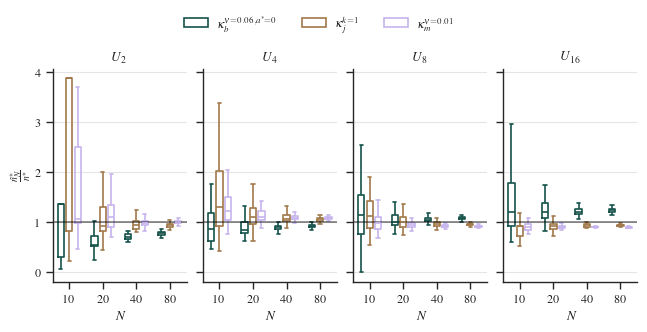

In [139]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns

mpl.rcParams['text.usetex'] = True                     # enable LaTeX
mpl.rcParams['text.latex.preamble'] = r"""
    \usepackage{mathptmx}
    \usepackage{amsmath}
    \usepackage{nicefrac}
"""
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman"],
})
sns.set(style="ticks", context="paper", font="serif")

statistic = "nstar_ratio"

linewidth = 6.5  # inches
fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(linewidth, 0.5*linewidth))
axes = axes.flatten()

groups = dfplot.groupby("distr_latex").groups

def sort_keys_by_subscript(d):
    def _extract_number(key):
        m = re.search(r'\{(\d+)\}', str(key))
        if m:
            return int(m.group(1))

        m = re.search(r'(\d+)', str(key))
        return int(m.group(1)) if m else float('inf')   # keys without a number go to the end

    sorted_keys = sorted(d.keys(), key=_extract_number)

    return sorted_keys

groups = OrderedDict({k: groups[k] for k in sort_keys_by_subscript(groups)})

handles, labels = None, None
for (distr_name, idx), ax in zip(groups.items(), axes):
    ax.set_title(distr_name)

    df_ = dfplot.iloc[idx, :]
    sns.boxplot(data=df_, x=pretty_columns["N"], y=pretty_columns[statistic], hue="kernel_latex", ax=ax, **boxplot_args)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()

    if statistic == "nstar_rel_error":
        ax.set_yticks([-1, -0.5, 0, 0.5, 1, 2, 3])
        ax.axhline(0, c="black", alpha=0.5)
    elif statistic == "nstar_ratio":
        ax.axhline(1, c="black", alpha=0.5)

    ax.grid(color="grey", alpha=0.2, axis="y")


sns.despine(top=True, right=True)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=.12, top=0.8)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0, 0.82 + 0.02, 1, 0.2),
           loc="center", borderaxespad=1, ncol=3, frameon=False)

fig.savefig(figures_dir / f"estimation_{statistic}.pdf")
